# Very Simple Linear Regression

Try a simple linear regression based model for predicting cross-domain correlation structures.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

In [2]:
ds = xr.open_zarr('../data/tcorr.predictors0.10lon.10lat.-1alev.-1olev.-1member.zarr')

### Quick look at correlations

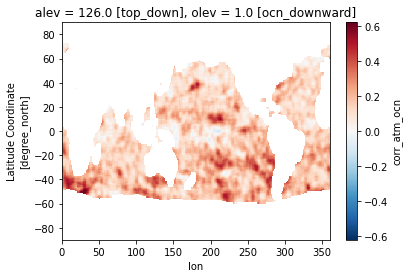

In [3]:
ds.corr_atm_ocn.isel(olev=0,alev=-1).plot()

## Prepare the data

### The output has more NaNs than the mask, so make a new mask

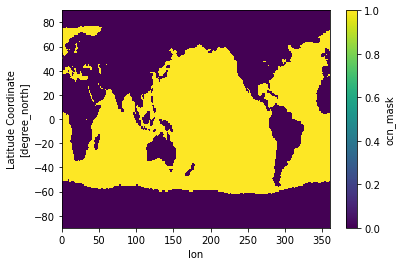

In [4]:
ds.ocn_mask.plot()

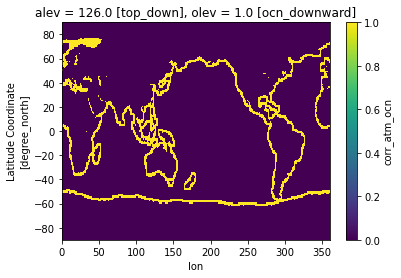

In [5]:
np.isnan(ds.corr_atm_ocn.where(ds.ocn_mask,0.).isel(alev=-1,olev=0)).plot()

In [6]:
ds['mask'] = ds.ocn_mask & ~np.isnan(ds.corr_atm_ocn).any(['alev','olev'])

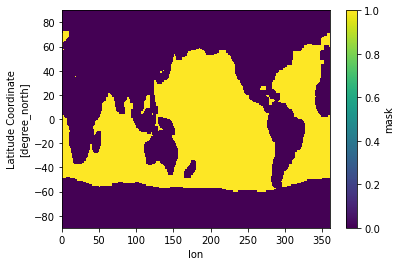

In [7]:
ds['mask'].plot()

### Stack lon/lat into single spatial dimension

Give this coordinate some trivial values so that xarray will plot without error

In [8]:
ds = ds.stack(x=('lat','lon')).reset_index('x')
ds['x'] = np.arange(len(ds.x))
ds

<xarray.Dataset>
Dimensions:               (alev: 74, member: 4, x: 64800, atm_hor: 1, olev: 44)
Coordinates:
  * alev                  (alev) float32 53.0 54.0 55.0 ... 124.0 125.0 126.0
  * atm_hor               (atm_hor) float32 0.0
  * member                (member) float64 9.5 29.5 49.5 69.5
  * olev                  (olev) float32 1.0 3.0 5.0 7.0 ... 356.5 405.6 461.6
  * x                     (x) int64 0 1 2 3 4 ... 64795 64796 64797 64798 64799
    lat                   (x) float32 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon                   (x) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Data variables: (12/52)
    atm_DZ                (member, alev, x) float32 dask.array<chunksize=(4, 74, 360), meta=np.ndarray>
    atm_T                 (member, alev, x) float32 dask.array<chunksize=(4, 74, 360), meta=np.ndarray>
    atm_W                 (member, alev, x) float32 dask.array<chunksize=(4, 74, 360), meta=np.ndarray>
    atm_ast               (member, x) float32 dask.array<chunksize=(4, 360), meta=np.ndarray>
    atm_cld_amt           (member, alev, x) float32 dask.array<chunksize=(4, 74, 360), meta=np.ndarray>
    atm_cnvprcp_ave       (member, x) float32 dask.array<chunksize=(4, 360), meta=np.ndarray>
    ...                    ...
    ocn_v                 (member, olev, x) float32 dask.array<chunksize=(4, 44, 360), meta=np.ndarray>
    ocn_v2                (member, olev, x) float32 dask.array<chunksize=(4, 44, 360), meta=np.ndarray>
    ocn_vbtav             (member, olev, x) float32 dask.array<chunksize=(4, 44, 360), meta=np.ndarray>
    ocn_vh                (member, olev, x) float32 dask.array<chunksize=(4, 44, 360), meta=np.ndarray>
    ocn_z                 (olev, x) float32 dask.array<chunksize=(44, 360), meta=np.ndarray>
    mask                  (x) bool dask.array<chunksize=(360,), meta=np.ndarray>
Attributes:
    filename:  /work2/noaa/gsienkf/weihuang/WCLEKF_PRODFORECAST/2015120500000...
    title:     Atmosphere, Ocean and Ice combined data

### Remove NaNs

Note that it's easier to do this after stacking lon/lat -> x.
Otherwise, have to be more precise with the `drop` operations.

In [9]:
print(f"Num. spatial points: {len(ds.lon)*len(ds.lat)}")

Num. spatial points: 4199040000


In [10]:
%%time
ds = ds.where(ds['mask'], drop=True)

CPU times: user 1min 27s, sys: 16.2 s, total: 1min 44s
Wall time: 1min 4s


In [11]:
print(f"Num. spatial points after removing land and ice: {len(ds.x)}")

Num. spatial points after removing land and ice: 24754


In [12]:
np.isnan(ds.corr_atm_ocn).sum().values

array(0)

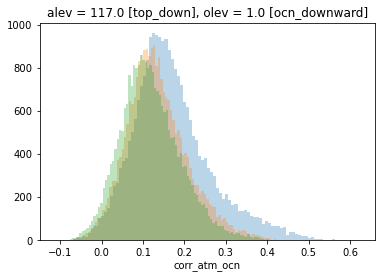

In [13]:
for alev in [-1, -5, -10]:
    ds.corr_atm_ocn.isel(olev=0,alev=alev).plot.hist(bins=100, alpha=.3);

### For now, just grab a few random variables to use...

Just as an example ... grabbing vector valued inputs from ocean, atmosphere, and scalars

In [14]:
ds['atm_speed_surf'] = ds['atm_wind_speed'].isel(alev=-1).drop('alev')

In [15]:
chosen_ones = ['ocn_Temp',
               'atm_T',
               'ocn_MLD',
               'atm_speed_surf',
               'corr_atm_ocn'
              ]

In [25]:
ds = ds[chosen_ones]
ds

<xarray.Dataset>
Dimensions:         (member: 4, olev: 44, x: 24754, alev: 74)
Coordinates:
  * alev            (alev) float32 53.0 54.0 55.0 56.0 ... 124.0 125.0 126.0
  * member          (member) float64 9.5 29.5 49.5 69.5
  * olev            (olev) float32 1.0 3.0 5.0 7.0 ... 313.8 356.5 405.6 461.6
  * x               (x) int64 11030 11031 11032 11033 ... 58327 58328 58329
    lat             (x) float64 -59.5 -59.5 -59.5 -59.5 ... 72.5 72.5 72.5 72.5
    lon             (x) float64 230.5 231.5 232.5 233.5 ... 6.5 7.5 8.5 9.5
Data variables:
    ocn_Temp        (member, olev, x) float32 dask.array<chunksize=(4, 44, 20), meta=np.ndarray>
    atm_T           (member, alev, x) float32 dask.array<chunksize=(4, 74, 20), meta=np.ndarray>
    ocn_MLD         (member, x) float32 dask.array<chunksize=(4, 20), meta=np.ndarray>
    atm_speed_surf  (member, x) float32 dask.array<chunksize=(4, 20), meta=np.ndarray>
    corr_atm_ocn    (alev, olev, x) float32 dask.array<chunksize=(74, 44, 20), meta=np.ndarray>
Attributes:
    filename:  /work2/noaa/gsienkf/weihuang/WCLEKF_PRODFORECAST/2015120500000...
    title:     Atmosphere, Ocean and Ice combined data

### Order dimensions, will come in handy later...

In [27]:
ds = ds.transpose('x','member','olev','alev')

### Separate into training and testing

Right now, only making this separation based on location, not separating samples.

TODO: fix this to play nicely with chunking if it becomes an issue

In [30]:
def random_indices(dim, fraction=0.8, random_seed=None):
    rstate = np.random.RandomState(random_seed)
    return rstate.choice(len(dim), size=int(len(dim)*fraction), replace=False)

def split_randomly(xds, dim='x', **kwargs):
    indices = random_indices(xds[dim], **kwargs)
    
    all_indices = np.arange(len(xds[dim]))
    others = np.array([i for i in all_indices if i not in indices])
    subset1 = xds.isel({dim:indices})
    subset2 = xds.isel({dim:others})
    return subset1, subset2
    

In [63]:
trainer, tester = split_randomly(ds)

/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 148 times more chunks
  return self.array[key]


### Split out labels and features/predictors

TODO: generalize this to multiple members

In [64]:
lbl = "corr_atm_ocn"
train_features = trainer.drop(lbl)
test_features = tester.drop(lbl)

train_labels = trainer[lbl]
test_labels = tester[lbl]

In [65]:
train_features['ocn_Temp']

<xarray.DataArray 'ocn_Temp' (x: 19803, member: 4, olev: 44)>
dask.array<getitem, shape=(19803, 4, 44), dtype=float32, chunksize=(2, 4, 44), chunktype=numpy.ndarray>
Coordinates:
  * member   (member) float64 9.5 29.5 49.5 69.5
  * olev     (olev) float32 1.0 3.0 5.0 7.0 9.005 ... 313.8 356.5 405.6 461.6
  * x        (x) int64 21301 27576 40876 43789 21134 ... 18393 26256 38343 47127
    lat      (x) float64 -30.5 -13.5 23.5 31.5 -31.5 ... -38.5 -17.5 16.5 40.5
    lon      (x) float64 61.5 216.5 196.5 229.5 254.5 ... 33.5 336.5 183.5 327.5
Attributes:
    _CoordinateAxes:  ocn_lev lat lon
    long_name:        Potential Temperature
    units:            degC

In [66]:
train_labels

<xarray.DataArray 'corr_atm_ocn' (x: 19803, olev: 44, alev: 74)>
dask.array<getitem, shape=(19803, 44, 74), dtype=float32, chunksize=(2, 44, 74), chunktype=numpy.ndarray>
Coordinates:
  * alev     (alev) float32 53.0 54.0 55.0 56.0 57.0 ... 123.0 124.0 125.0 126.0
  * olev     (olev) float32 1.0 3.0 5.0 7.0 9.005 ... 313.8 356.5 405.6 461.6
  * x        (x) int64 21301 27576 40876 43789 21134 ... 18393 26256 38343 47127
    lat      (x) float64 -30.5 -13.5 23.5 31.5 -31.5 ... -38.5 -17.5 16.5 40.5
    lon      (x) float64 61.5 216.5 196.5 229.5 254.5 ... 33.5 336.5 183.5 327.5

### Flatten the output vector to a generalized vertical coordinate

Note that I'm not doing this before separating features from labels because features/predictors are only in one domain, and it will fill the "empty domain". Seems unnecessary 

In [67]:
train_labels = train_labels.stack(z=('alev','olev'))
test_labels = test_labels.stack(z=('alev','olev'))

### For the features, flatten the `member` and `x` dimensions to just one `sample` dimension...

In [68]:
#train_features = train_features.stack(sample=('member','x'))
#test_features = test_features.stack(sample=('member','x'))

### Normalization

Rather than do this with keras, it seems easier and more robust to create an xarray based object to do it...

In [69]:
class XNormalizer():
    mean = None
    std = None
    def __init__(self, dims="",):
        """
        Args:
            dims (str or list of str): dimension to apply operation along
        """
        self.dims = dims
        
        
    def __call__(self, arr):
        """Apply standard normalization: (arr - mean) / std
        using :attr:`mean` and :attr:`std`: set by :meth:`adapt` 
        """
        return (arr - self.mean) / self.std
    
        
    def adapt(self, arr):
        """Compute mean and std, use this to normalize other arrays
        
        Sets Attributes:
            mean (:obj:`xarray.DataArray`): arr.mean(self.dims)
            std (:obj:`xarray.DataArray`): arr.std(self.dims)
        """
        self.mean = arr.mean(self.dims)
        self.std = arr.std(self.dims)

In [70]:
xn = XNormalizer(dims=('x','member'))

In [71]:
xn.adapt(train_features.ocn_Temp)

These are just some checks to make sure it's normalizing like normal

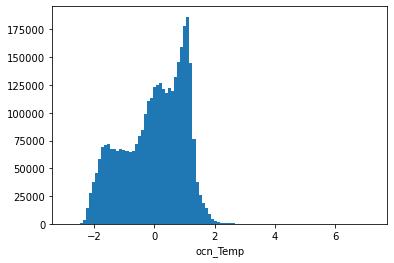

In [72]:
xn(train_features.ocn_Temp).plot.hist(bins=100);

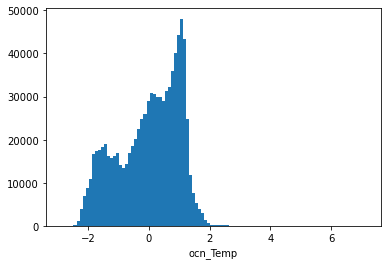

In [73]:
xn(test_features.ocn_Temp).plot.hist(bins=100);

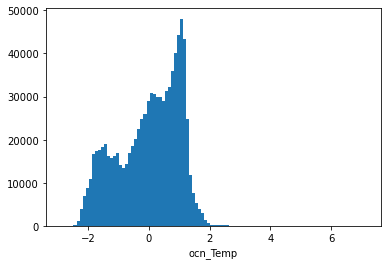

In [74]:
(
    (test_features.ocn_Temp - train_features.ocn_Temp.mean(('x','member'))) /
    train_features.ocn_Temp.std(('x','member'))
).plot.hist(bins=100);

Well, it's not very normal, but I guess we'll see how this goes

### Normalize the inputs

For now, bring them into memory...

In [75]:
dims = ('x','member')
otn = XNormalizer(dims=dims)
otn.adapt(train_features['ocn_Temp'])

omn = XNormalizer(dims=dims)
omn.adapt(train_features['ocn_MLD'])

atn = XNormalizer(dims=dims)
atn.adapt(train_features['atm_T'])

asn = XNormalizer(dims=dims)
asn.adapt(train_features['atm_speed_surf'])

In [76]:
train_features

<xarray.Dataset>
Dimensions:         (x: 19803, member: 4, olev: 44, alev: 74)
Coordinates:
  * alev            (alev) float32 53.0 54.0 55.0 56.0 ... 124.0 125.0 126.0
  * member          (member) float64 9.5 29.5 49.5 69.5
  * olev            (olev) float32 1.0 3.0 5.0 7.0 ... 313.8 356.5 405.6 461.6
  * x               (x) int64 21301 27576 40876 43789 ... 26256 38343 47127
    lat             (x) float64 -30.5 -13.5 23.5 31.5 ... -38.5 -17.5 16.5 40.5
    lon             (x) float64 61.5 216.5 196.5 229.5 ... 336.5 183.5 327.5
Data variables:
    ocn_Temp        (x, member, olev) float32 dask.array<chunksize=(1, 4, 44), meta=np.ndarray>
    atm_T           (x, member, alev) float32 dask.array<chunksize=(1, 4, 74), meta=np.ndarray>
    ocn_MLD         (x, member) float32 dask.array<chunksize=(1, 4), meta=np.ndarray>
    atm_speed_surf  (x, member) float32 dask.array<chunksize=(1, 4), meta=np.ndarray>
Attributes:
    filename:  /work2/noaa/gsienkf/weihuang/WCLEKF_PRODFORECAST/2015120500000...
    title:     Atmosphere, Ocean and Ice combined data

In [77]:
%%time
dims = ('x','member')
train_features_eager = {}
test_features_eager = {}

for key in ['ocn_Temp','ocn_MLD','atm_T','atm_speed_surf']:
    normalizer = XNormalizer(dims=dims)
    normalizer.adapt(train_features[key])
    
    train_features_eager[key] = normalizer(train_features[key]).load();
    test_features_eager[key] = normalizer(test_features[key]).load();

CPU times: user 2min 44s, sys: 20.6 s, total: 3min 4s
Wall time: 2min 45s


### Bring labels into memory too...

In [78]:
%%time
train_labels = train_labels.load();
train_labels = train_labels.load();

CPU times: user 7.22 s, sys: 863 ms, total: 8.08 s
Wall time: 6.14 s


## Create the model

For vector valued input (e.g. `ocn_Temp`), keras wants this to be organized with the vector as the last dimension, hence the reordering of dimensions earlier

Create each input layer

In [110]:
ocn_temp_input = keras.Input(
    shape=(len(ds.member),len(ds.olev),), name="ocn_Temp"
)
ocn_mxl_input = keras.Input(
    shape=(len(ds.member), 1,), name="ocn_MLD"
)
atm_temp_input = keras.Input(
    shape=(len(ds.member), len(ds.alev),), name='atm_T'
)
atm_spd_input = keras.Input(
    shape=(len(ds.member),1,), name='atm_speed_surf'
)

Then merge it all together

In [111]:
merge = keras.layers.concatenate(
    [ocn_temp_input, ocn_mxl_input, atm_temp_input, atm_spd_input]
)

For now, using merged vertical coordinate

In [112]:
output = keras.layers.Dense(
    units=len(train_labels.z), name="ao_corr"
)(merge)

In [113]:
model = keras.Model(
    inputs=[ocn_temp_input, ocn_mxl_input, atm_temp_input, atm_spd_input],
    outputs=[output]
)

In [115]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ocn_Temp (InputLayer)          [(None, 4, 44)]      0           []                               
                                                                                                  
 ocn_MLD (InputLayer)           [(None, 4, 1)]       0           []                               
                                                                                                  
 atm_T (InputLayer)             [(None, 4, 74)]      0           []                               
                                                                                                  
 atm_speed_surf (InputLayer)    [(None, 4, 1)]       0           []                               
                                                                                            

Size is bias vector + matrix ... good

In [116]:
74*44 + 120*(74*44)

393976

### Determine optimization process and train it

For now, use MSE loss function and Adam optimization.
Options in [keras regression losses](https://keras.io/api/losses/regression_losses/)
and [keras optimizers](https://keras.io/api/optimizers/) 

- How big should the batch size be?
- How many epochs?
- What learning rate to use?
- How to do this in parallel rather than pulling everything into memory here?

In [117]:
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.05 #no idea on hyper parameters)
    ),
    loss=keras.losses.MeanSquaredError()
)

In [118]:
train_features_eager['ocn_Temp']

<xarray.DataArray 'ocn_Temp' (x: 19803, member: 4, olev: 44)>
array([[[ 0.23414494,  0.23483652,  0.23535195, ...,  0.85806113,
          1.1531198 ,  1.485512  ],
        [ 0.23177719,  0.23248416,  0.23300451, ...,  0.8596567 ,
          1.1558428 ,  1.4840007 ],
        [ 0.23341347,  0.23410828,  0.23462875, ...,  0.8600558 ,
          1.1542332 ,  1.4873149 ],
        [ 0.23159945,  0.23228808,  0.2328017 , ...,  0.8578082 ,
          1.155376  ,  1.4838806 ]],

       [[ 1.0873432 ,  1.085529  ,  1.084862  , ...,  0.7100191 ,
          0.28859687, -0.0206969 ],
        [ 1.0867692 ,  1.084947  ,  1.0842708 , ...,  0.67338264,
          0.25297457, -0.03924709],
        [ 1.0854626 ,  1.0836558 ,  1.0829991 , ...,  0.6880305 ,
          0.25129858, -0.0468049 ],
        [ 1.0865268 ,  1.084706  ,  1.0840429 , ...,  0.67689544,
          0.24811006, -0.05169583]],

       [[ 0.7367471 ,  0.7359861 ,  0.7357958 , ...,  0.08958647,
         -0.11866542, -0.28640068],
...
        [ 0.6536172 ,  0.6541969 ,  0.6546555 , ...,  0.4957786 ,
          0.36589178,  0.13632542]],

       [[ 0.9848707 ,  0.9839663 ,  0.98370916, ..., -0.35082522,
         -0.42720556, -0.45599288],
        [ 0.9826355 ,  0.981695  ,  0.98141944, ..., -0.34704503,
         -0.4191761 , -0.44938534],
        [ 0.9825521 ,  0.9816156 ,  0.9813431 , ..., -0.37472594,
         -0.43801296, -0.45239562],
        [ 0.9838734 ,  0.9829442 ,  0.9826744 , ..., -0.35516348,
         -0.429174  , -0.4541281 ]],

       [[-0.42378867, -0.42341864, -0.42291647, ...,  0.97416496,
          1.208621  ,  1.3969669 ],
        [-0.42268562, -0.42231545, -0.42181444, ...,  0.98384064,
          1.2165012 ,  1.4049764 ],
        [-0.42289504, -0.4224836 , -0.42196044, ...,  0.978872  ,
          1.223065  ,  1.4092855 ],
        [-0.42318252, -0.4228087 , -0.42230132, ...,  0.9839702 ,
          1.2202061 ,  1.3997049 ]]], dtype=float32)
Coordinates:
  * member   (member) float64 9.5 29.5 49.5 69.5
  * olev     (olev) float32 1.0 3.0 5.0 7.0 9.005 ... 313.8 356.5 405.6 461.6
  * x        (x) int64 21301 27576 40876 43789 21134 ... 18393 26256 38343 47127
    lat      (x) float64 -30.5 -13.5 23.5 31.5 -31.5 ... -38.5 -17.5 16.5 40.5
    lon      (x) float64 61.5 216.5 196.5 229.5 254.5 ... 33.5 336.5 183.5 327.5

In [119]:
train_labels

<xarray.DataArray 'corr_atm_ocn' (x: 19803, z: 3256)>
array([[ 0.051317  ,  0.0513504 ,  0.05085516, ..., -0.0983383 ,
        -0.1221178 , -0.07038209],
       [ 0.00245028,  0.00260224,  0.00215656, ...,  0.09902062,
         0.08530671,  0.08537504],
       [-0.07617413, -0.07651054, -0.07661074, ..., -0.14178956,
        -0.10966858, -0.04752829],
       ...,
       [ 0.04542768,  0.04551881,  0.04512217, ...,  0.05297013,
        -0.00991462, -0.05453311],
       [-0.05246897, -0.04407572, -0.04008194, ...,  0.05185859,
         0.0356286 ,  0.01664147],
       [ 0.00680018,  0.00633062,  0.0060774 , ..., -0.02242921,
         0.03739351,  0.0663838 ]], dtype=float32)
Coordinates:
  * x        (x) int64 21301 27576 40876 43789 21134 ... 18393 26256 38343 47127
    lat      (x) float64 -30.5 -13.5 23.5 31.5 -31.5 ... -38.5 -17.5 16.5 40.5
    lon      (x) float64 61.5 216.5 196.5 229.5 254.5 ... 33.5 336.5 183.5 327.5
  * z        (z) object MultiIndex
  * alev     (z) float32 53.0 53.0 53.0 53.0 53.0 ... 126.0 126.0 126.0 126.0
  * olev     (z) float32 1.0 3.0 5.0 7.0 9.005 ... 276.6 313.8 356.5 405.6 461.6

In [126]:
tt = train_labels.expand_dims({'member':[1]}).transpose('x','member','z')
ttv = tt.values

In [130]:
%%time
history = model.fit(
    x={k:train_features_eager[k].values for k in ['ocn_Temp','ocn_MLD','atm_T','atm_speed_surf'] 
      },
    y=ttv,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
)

Epoch 1/20
496/496 [==============================] - 3s 5ms/step - loss: 0.0719 - val_loss: 0.0445
Epoch 2/20
496/496 [==============================] - 2s 5ms/step - loss: 0.0615 - val_loss: 0.0576
Epoch 3/20
496/496 [==============================] - 2s 5ms/step - loss: 0.0724 - val_loss: 0.0837
Epoch 4/20
496/496 [==============================] - 2s 5ms/step - loss: 0.0596 - val_loss: 0.0276
Epoch 5/20
496/496 [==============================] - 2s 5ms/step - loss: 0.0833 - val_loss: 0.0651
Epoch 6/20
496/496 [==============================] - 2s 5ms/step - loss: 0.0853 - val_loss: 0.0465
Epoch 7/20
496/496 [==============================] - 2s 5ms/step - loss: 0.0641 - val_loss: 0.0673
Epoch 8/20
496/496 [==============================] - 2s 5ms/step - loss: 0.0722 - val_loss: 0.1301
Epoch 9/20
496/496 [==============================] - 2s 5ms/step - loss: 0.0747 - val_loss: 0.0657
Epoch 10/20
496/496 [==============================] - 3s 5ms/step - loss: 0.0948 - val_loss: 0.0256

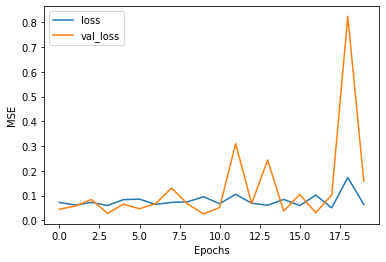

In [131]:
fig,ax=plt.subplots()
for key in ['loss','val_loss']:
    ax.plot(history.history[key],label=key)
ax.set(xlabel='Epochs', ylabel='MSE')
ax.legend()

In [133]:
tv = test_labels.expand_dims({'member':[1]}).transpose('x','member','z')
tvv = tv.values

In [135]:
model.evaluate(
    x={k:test_features_eager[k].values for k in ['ocn_Temp','ocn_MLD','atm_T','atm_speed_surf'] 
      },
    y=tvv
)

155/155 [==============================] - 0s 2ms/step - loss: 0.1585


0.1585005223751068

In [140]:
prediction = model.predict({k:test_features_eager[k].values for k in test_features.data_vars})

155/155 [==============================] - 0s 2ms/step


In [142]:
prediction.shape

(4951, 4, 3256)

In [143]:
test_labels.shape

(4951, 3256)

In [145]:
xpred = xr.DataArray(prediction,coords={'x':test_labels.x, 'member':ds.member, 'z':test_labels.z},
                     dims=('x','member','z'))

In [147]:
xpred = xpred.unstack('z')

[Text(0.5, 0, 'Truth'), Text(0, 0.5, 'Prediction')]

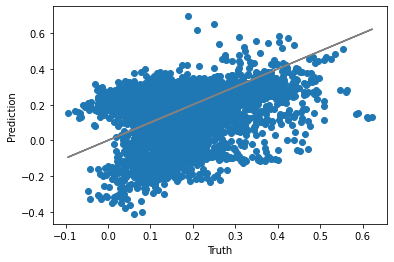

In [157]:
fig, ax = plt.subplots()
ax.scatter(test_labels.unstack('z').isel(alev=-1,olev=0),
           xpred.isel(alev=-1,olev=0).isel(member=0),
          )
ax.plot(test_labels.unstack('z').isel(alev=-1,olev=0),test_labels.unstack('z').isel(alev=-1,olev=0),color='gray')
ax.set(xlabel='Truth',ylabel='Prediction')